This project involves scraping data from an e-commerce website and creating a list of all products currently offered on discount.
perfotm EDA on the data .
This project is part of the luxEA bootcamp.
technologies used include pyhton,beautiful soup,selenium,scrapy,pandas

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import time
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import warnings
from scipy import stats  # Import stats from scipy



In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set up Chrome options
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Create a Service object using ChromeDriverManager
service = Service(ChromeDriverManager().install())

# Initialize the Chrome WebDriver
driver = webdriver.Chrome(service=service, options=chrome_options)

2024-09-05 12:21:43,367 - INFO - ====== WebDriver manager ======
2024-09-05 12:21:45,889 - INFO - Get LATEST chromedriver version for google-chrome
2024-09-05 12:21:46,860 - INFO - Get LATEST chromedriver version for google-chrome
2024-09-05 12:21:47,818 - INFO - Driver [C:\Users\user\.wdm\drivers\chromedriver\win64\128.0.6613.119\chromedriver-win32/chromedriver.exe] found in cache


In [3]:
# Define a list to hold product information
products = []

def clean_price(price):
    if pd.isna(price) or price in ['No current price', 'No old price', 0]:
        return 0
    
    if isinstance(price, float):
        return price
    
    if isinstance(price, str):
        price = price.replace('KSh ', '').replace(',', '')
        price = re.sub(r'[^\d.]', '', price)
    
    try:
        return float(price)
    except ValueError:
        logging.warning(f"Unable to convert '{price}' to float")
        return 0

def extract_name(article):
    # Try different selectors for name
    selectors = [
        ('h3', 'name'),
        ('div', 'name'),
        ('a', 'core')
    ]
    
    for tag, class_name in selectors:
        name_elem = article.find(tag, class_=class_name)
        if name_elem:
            return name_elem.text.strip()
    
    logging.warning("Unable to find product name")
    return 'No name'


In [4]:

def extract_lower_price(price_text):
    prices = re.findall(r'KSh ([\d,]+)', price_text)
    if prices:
        return min(float(price.replace(',', '')) for price in prices)
    return 0

def scrape_page(url):
    driver.get(url)
    wait = WebDriverWait(driver, 20)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'article.prd')))
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    articles = soup.find_all('article', class_='prd')
    
    for article in articles:
        try:
            name = extract_name(article)
            # Extract current price
            price_div = article.find('div', class_='prc')
            current_price = extract_lower_price(price_div.text.strip()) if price_div else 0
            old_price = clean_price(price_div.get('data-oprc', '0').strip()) if price_div else 0
            
            discount_div = article.find('div', class_=lambda x: x and '_dsct' in x.split())
            discount = discount_div.text.strip() if discount_div else 'No discount'
            
            rating_elem = article.find('div', class_='stars _s')
            if rating_elem:
                rating_style = rating_elem.find('div', class_='in')['style'] if rating_elem.find('div', class_='in') else ''
                rating = re.search(r'width:(\d+)%', rating_style)
                rating = f"{rating.group(1)}%" if rating else 'No rating'
            else:
                rating = 'No rating'
            
            core_elem = article.find('a', class_='core')
            brand = core_elem.get('data-brand') or core_elem.get('data-gtm-brand') if core_elem else 'No brand'
            category = core_elem.get('data-category') or core_elem.get('data-gtm-category') if core_elem else 'No category'
            
            product = {
                'name': name,
                'price': current_price,
                'old_price': old_price,
                'discount': discount,
                'rating': rating,
                'brand': brand,
                'category': category
            }
            products.append(product)
            logging.info(f"Scraped product: {product}")
        except Exception as e:
            logging.error(f"Error processing product: {e}", exc_info=True)
            continue

In [ ]:
def scrape_page_set(start_page, end_page):
    for page in range(start_page, end_page + 1):
        url = f'https://www.jumia.co.ke/mlp-fulfilled-by-jumia/?shop_premium_services=shop_express&shipped_from=country_local&page={page}#catalog-listing'
        logging.info(f'Scraping page {page}...')
        scrape_page(url)
        time.sleep(2)

total_pages = 40
pages_per_set = 10
num_sets = total_pages // pages_per_set

for set_num in range(num_sets):
    start_page = set_num * pages_per_set + 1
    end_page = start_page + pages_per_set - 1
    logging.info(f"\nScraping set {set_num + 1} (pages {start_page}-{end_page})...")
    scrape_page_set(start_page, end_page)
    
    if set_num < num_sets - 1:
        logging.info(f"Pausing for 30 seconds before the next set...")
        time.sleep(30)

driver.quit()

2024-09-05 12:21:52,770 - INFO - 
Scraping set 1 (pages 1-10)...
2024-09-05 12:21:52,772 - INFO - Scraping page 1...
2024-09-05 12:21:56,721 - INFO - Scraped product: {'name': 'Black Portable Outdoor Mountaineering Beer Belt For Men', 'price': 493.0, 'old_price': 1094.0, 'discount': '55%', 'rating': 'No rating', 'brand': 'Generic', 'category': 'Sporting Goods/Outdoor Recreation/Camping & Hiking/Backpacks & Bags/Daypacks & Casual Bags/Waist Packs'}
2024-09-05 12:21:56,724 - INFO - Scraped product: {'name': 'Universal Negative Ion Supercharged Shower Head', 'price': 748.0, 'old_price': 1496.0, 'discount': '50%', 'rating': 'No rating', 'brand': 'Generic', 'category': 'Home & Office/Home & Kitchen/Bath/Bathroom Accessories/Showerheads'}
2024-09-05 12:21:56,735 - INFO - Scraped product: {'name': 'Dimmable LED Panel Book Reading Lamp Eye Protect For Night', 'price': 739.0, 'old_price': 1478.0, 'discount': '50%', 'rating': 'No rating', 'brand': 'Generic', 'category': 'Home & Office/Home & Kit

In [154]:
df = pd.DataFrame(products)
df.to_csv('discounted_products.csv', index=False, encoding='utf-8')
logging.info('Data has been written to discounted_products.csv')



2024-09-05 13:54:48,655 - INFO - Data has been written to discounted_products.csv


In [104]:
logging.info(f"Total products scraped: {len(df)}")
logging.info(f"Products with 'No name': {df['name'].value_counts().get('No name', 0)}")
logging.info(f"Products with 'No price': {df['price'].value_counts().get('No price', 0)}")
logging.info(f"Products with 'No old price': {df['old_price'].value_counts().get('No old price', 0)}")
logging.info(f"Products with 'No discount': {df['discount'].value_counts().get('No discounts', 0)}")
logging.info(f"Products with 'No rating': {df['name'].value_counts().get('No rating', 0)}")
logging.info(f"Unique brands: {df['brand'].nunique()}")
logging.info(f"Unique categories: {df['category'].nunique()}")

2024-09-05 13:41:16,730 - INFO - Total products scraped: 3640
2024-09-05 13:41:16,736 - INFO - Products with 'No name': 0
2024-09-05 13:41:16,739 - INFO - Products with 'No price': 0
2024-09-05 13:41:16,742 - INFO - Products with 'No old price': 0
2024-09-05 13:41:16,746 - INFO - Products with 'No discount': 0
2024-09-05 13:41:16,752 - INFO - Products with 'No rating': 0
2024-09-05 13:41:16,757 - INFO - Unique brands: 53
2024-09-05 13:41:16,763 - INFO - Unique categories: 483


In [226]:
df = pd.read_csv(r'C:\Users\user\discounted_products.csv')

# view the first few details of the data
df.head()

,name,price,old_price,discount,rating,brand,category
0,Black Portable Outdoor Mountaineering Beer Bel...,493.0,1094.0,55%,No rating,Generic,Sporting Goods/Outdoor Recreation/Camping & Hi...
1,Universal Negative Ion Supercharged Shower Head,748.0,1496.0,50%,No rating,Generic,Home & Office/Home & Kitchen/Bath/Bathroom Acc...
2,Dimmable LED Panel Book Reading Lamp Eye Prote...,739.0,1478.0,50%,No rating,Generic,Home & Office/Home & Kitchen/Lighting & Ceilin...
3,Outdoor Self-Defense Equipment Keyholder For W...,210.0,420.0,50%,No rating,Generic,Home & Office/Office Products/Office & School ...
4,5 In 1 Headphone Cleaning Pen Computer Keyboar...,370.0,740.0,50%,No rating,Generic,Home & Office/Home & Kitchen/Kitchen & Dining/...


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       3640 non-null   object 
 1   price      3640 non-null   float64
 2   old_price  3640 non-null   float64
 3   discount   3640 non-null   object 
 4   rating     3640 non-null   object 
 5   brand      3640 non-null   object 
 6   category   3640 non-null   object 
dtypes: float64(2), object(5)
memory usage: 199.2+ KB


In [228]:
#remove the % sign from the discount column
df['discount'] = df['discount'].str.replace('%', '', regex=False)

#drop the rating column
df = df.drop(columns = ['rating'])
df.head()

,name,price,old_price,discount,brand,category
0,Black Portable Outdoor Mountaineering Beer Bel...,493.0,1094.0,55,Generic,Sporting Goods/Outdoor Recreation/Camping & Hi...
1,Universal Negative Ion Supercharged Shower Head,748.0,1496.0,50,Generic,Home & Office/Home & Kitchen/Bath/Bathroom Acc...
2,Dimmable LED Panel Book Reading Lamp Eye Prote...,739.0,1478.0,50,Generic,Home & Office/Home & Kitchen/Lighting & Ceilin...
3,Outdoor Self-Defense Equipment Keyholder For W...,210.0,420.0,50,Generic,Home & Office/Office Products/Office & School ...
4,5 In 1 Headphone Cleaning Pen Computer Keyboar...,370.0,740.0,50,Generic,Home & Office/Home & Kitchen/Kitchen & Dining/...


In [229]:
# Identify products where the original price is missing or (0) but a discount is applied.
# Calculates the original price for these products based on the current price and discount.
def calc_original_price(row):
    if row['old_price'] == 0 and row['discount'] != 'No Discount':
        try:
            discount_percentage = float(row['discount'].strip('%'))
            original_price = row['price']/(1-discount_percentage/100)
            return round(original_price, 0)
        except ValueError:
            return row['old_price']
    else:
        return row['old_price']

# Updates the 'old_price' column with these calculated values.
df['old_price']=df.apply(calc_original_price, axis = 1)


#Ensures all prices in the 'old_price' column are whole numbers.
df['old_price']=df['old_price'].round().astype(int)

# drop items where there are no discounts
df = df[df['discount'] != 'No discount']

df

,name,price,old_price,discount,brand,category
0,Black Portable Outdoor Mountaineering Beer Bel...,493.0,1094,55,Generic,Sporting Goods/Outdoor Recreation/Camping & Hi...
1,Universal Negative Ion Supercharged Shower Head,748.0,1496,50,Generic,Home & Office/Home & Kitchen/Bath/Bathroom Acc...
2,Dimmable LED Panel Book Reading Lamp Eye Prote...,739.0,1478,50,Generic,Home & Office/Home & Kitchen/Lighting & Ceilin...
3,Outdoor Self-Defense Equipment Keyholder For W...,210.0,420,50,Generic,Home & Office/Office Products/Office & School ...
4,5 In 1 Headphone Cleaning Pen Computer Keyboar...,370.0,740,50,Generic,Home & Office/Home & Kitchen/Kitchen & Dining/...
...,...,...,...,...,...,...
3635,Fashion Jade Amulet Unisex Necklace Natural Ha...,170.0,298,43,Fashion,Fashion/Men's Fashion/Jewelry/Necklaces
3636,Travel Electric Kettle Electric Heating Water ...,2045.0,2556,20,Generic,Home & Office/Appliances/Small Appliances/Kett...
3637,Curren New Brand Fashion Quartz Men Watch PU L...,1000.0,2000,50,Curren,Fashion/Watches & Sunglasses/Men's Watches
3638,"Rubber O-Ring Classification Kit, 225 Pieces",1080.0,1521,29,Generic,Garden & Outdoors/Farm & Ranch/Agricultural & ...


In [230]:

# convert all values to floats, making the column numeric.
# Selects the top 10 products with the highest discounts.
df['discount'] = df['discount'].astype(float)
top_discounts = df.nlargest(10, 'discount')
top_discounts

df

,name,price,old_price,discount,brand,category
0,Black Portable Outdoor Mountaineering Beer Bel...,493.0,1094,55.0,Generic,Sporting Goods/Outdoor Recreation/Camping & Hi...
1,Universal Negative Ion Supercharged Shower Head,748.0,1496,50.0,Generic,Home & Office/Home & Kitchen/Bath/Bathroom Acc...
2,Dimmable LED Panel Book Reading Lamp Eye Prote...,739.0,1478,50.0,Generic,Home & Office/Home & Kitchen/Lighting & Ceilin...
3,Outdoor Self-Defense Equipment Keyholder For W...,210.0,420,50.0,Generic,Home & Office/Office Products/Office & School ...
4,5 In 1 Headphone Cleaning Pen Computer Keyboar...,370.0,740,50.0,Generic,Home & Office/Home & Kitchen/Kitchen & Dining/...
...,...,...,...,...,...,...
3635,Fashion Jade Amulet Unisex Necklace Natural Ha...,170.0,298,43.0,Fashion,Fashion/Men's Fashion/Jewelry/Necklaces
3636,Travel Electric Kettle Electric Heating Water ...,2045.0,2556,20.0,Generic,Home & Office/Appliances/Small Appliances/Kett...
3637,Curren New Brand Fashion Quartz Men Watch PU L...,1000.0,2000,50.0,Curren,Fashion/Watches & Sunglasses/Men's Watches
3638,"Rubber O-Ring Classification Kit, 225 Pieces",1080.0,1521,29.0,Generic,Garden & Outdoors/Farm & Ranch/Agricultural & ...


In [231]:
df.describe()

,price,old_price,discount
count,3629.000000,3.629000e+03,3629.000000
mean,936.289611,1.534718e+05,41.712869
std,1396.175522,1.438920e+06,10.271947
min,62.000000,1.220000e+02,1.000000
25%,450.000000,7.820000e+02,36.000000
50%,625.000000,1.094000e+03,45.000000
75%,937.000000,1.536000e+03,50.000000
max,39888.000000,1.378150e+07,65.000000


In [232]:

# Assuming your DataFrame is named 'df'
def identify_outliers_zscore(df, column, threshold=3):
  
    mean = df[column].mean()
    std = df[column].std()

    z_scores = (df[column] - mean) / std
    outliers = df[abs(z_scores) > threshold]

    return outliers

# Example usage
price_outliers = identify_outliers_zscore(df, 'price', threshold=3)
old_price_outliers = identify_outliers_zscore(df, 'old_price', threshold=3)

print("Price outliers:")
print(price_outliers)

print("Old price outliers:")
print(old_price_outliers)

Price outliers:
                                                   name    price  old_price  \
65    Huawei Y7 Pro 4G LTE, 6.26", 4GB +128GB, Dual ...   8067.0      16463   
71    Hikers 43'' Inch Frameless Android Smart FHD L...  18820.0      26507   
73        Hikers 32'' Digital Frameless HD LED TV-Black  11035.0      15993   
252   Y6 Pro Smartphone 5.0" Touch Display 64 GB ROM...   6299.0      12598   
524   Oppo Refurbished A83 4GB+ 64GB Smartphone - 4G...   7667.0      12778   
536   C Idea Adults Tablets10 Inches Android 12 Sim ...  12999.0      22805   
605   C Idea 10.1 Inch Android Tablet PC 12 Dual Cam...  13607.0      20934   
611   Oppo A31 6GB RAM+128G ROM Refurbished 6.5 Inch...   9899.0      18677   
797   X Tigi HeroBook 10.1"- Android - Quad Core-3Gb...   9999.0      19606   
875   Hikers 55'' Frameless Android Smart 4K LED TV ...  39888.0      69979   
1059  Freeyond M5,8GB+128GB,6.52", 50MP,4G Smartphon...  11567.0      22680   
1079  Huawei Y6 Pro 5.0" Touch Displ

In [233]:
# identify rows where the price value is greater than 100000 as they may have been incorrectly scrapped
filtered_df = df[df['old_price'] > 100000]
filtered_df

,name,price,old_price,discount,brand,category
40,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
131,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
222,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
313,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
404,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
495,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
586,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
677,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
768,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...
859,Fashion Men's Hawaiian Ink Print Bottom-down ...,960.0,13781500,36.0,Fashion,Fashion/Men's Fashion/Clothing/Shirts/Casual B...


In [234]:
df['old_price'] = pd.to_numeric(df['old_price'], errors='coerce')

df.loc[df['old_price'] > 100000, 'old_price'] = df.loc[df['old_price'] > 100000, 'old_price'].astype(str).str[:4].astype(int)


In [239]:
df.describe()

,price,old_price,discount
count,3629.000000,3629.000000,3629.000000
mean,936.289611,1582.910168,41.712869
std,1396.175522,2366.429540,10.271947
min,62.000000,122.000000,1.000000
25%,450.000000,782.000000,36.000000
50%,625.000000,1094.000000,45.000000
75%,937.000000,1531.000000,50.000000
max,39888.000000,69979.000000,65.000000


In [247]:
correlation_price_discount = df[['price', 'discount']].corr()
correlation_price_discount

,price,discount
price,1.00000,-0.16654
discount,-0.16654,1.00000


The correlation coefficient is -0.16654, which indicates a weak negative correlation between price and discount
There is a slight tendency for the discount to be lower as the price increases, but the relationship is weak. This suggests that while there may be a trend, it is not strong.

In [254]:
brand_count= df['brand'].nunique()
brand_count

52

In [255]:
# Category analysis
category_counts = df['category'].nunique()
category_counts


480

In [258]:
#average price by brand
avg_price_by_brand = df.groupby('brand')['price'].mean().reset_index()
print("Average price by brand:\n", avg_price_by_brand)


Average price by brand:
                   brand         price
0                ALagzi   1090.000000
1              ARHANORY    465.000000
2                ASHION   1340.000000
3              Ace Elec    421.666667
4               Agapeon    421.250000
5                   Att    149.000000
6                 BOMGE   3200.000000
7              Backpack   1499.000000
8               Binbond   1280.000000
9                C Idea   8861.285714
10              Catpapa   1299.666667
11                Cidea   4859.000000
12               Curren   1133.000000
13               Deliya   1680.000000
14              Edifier   4394.500000
15               Fahion    868.333333
16              Fashion    739.079509
17             Freeyond   7816.000000
18              Genelec   3199.000000
19               Genera   1460.000000
20     General Electric   1118.000000
21  General Electronics   1599.000000
22              Generic    855.777001
23              Genetic    721.333333
24               Gogoey  

In [257]:
#average price by category
avg_price_by_category = df.groupby('category')['price'].mean().reset_index()
print("Average price by category:\n", avg_price_by_category)

Average price by category:
                                               category        price
0    Automobile/Car Care/Exterior Care/Car Wash Equ...  2058.000000
1    Automobile/Car Electronics & Accessories/Car E...   382.500000
2    Automobile/Car Electronics & Accessories/Car E...  4650.000000
3    Automobile/Car Electronics & Accessories/Car E...  2190.000000
4    Automobile/Car Electronics & Accessories/Car E...  2500.000000
..                                                 ...          ...
475  Sporting Goods/Sports & Fitness/Hunting & Fish...  2630.000000
476  Sporting Goods/Sports & Fitness/Hunting & Fish...   586.666667
477  Toys & Games/Kids' Furniture, Décor & Storage/...  3450.000000
478  Toys & Games/Learning & Education/Musical Inst...   899.000000
479  Toys & Games/Stuffed Animals & Plush Toys/Plus...   895.000000

[480 rows x 2 columns]


C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


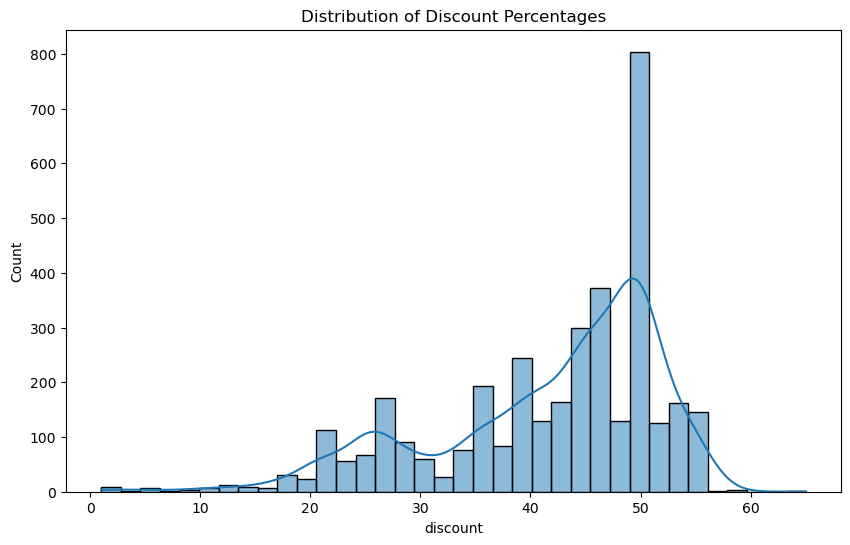

In [266]:
# Distribution of discounts
plt.figure(figsize=(10, 6))
sns.histplot(df['discount'], kde=True)
plt.title('Distribution of Discount Percentages')
plt.savefig('discount_distribution.png')
plt.show()
plt.close()

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


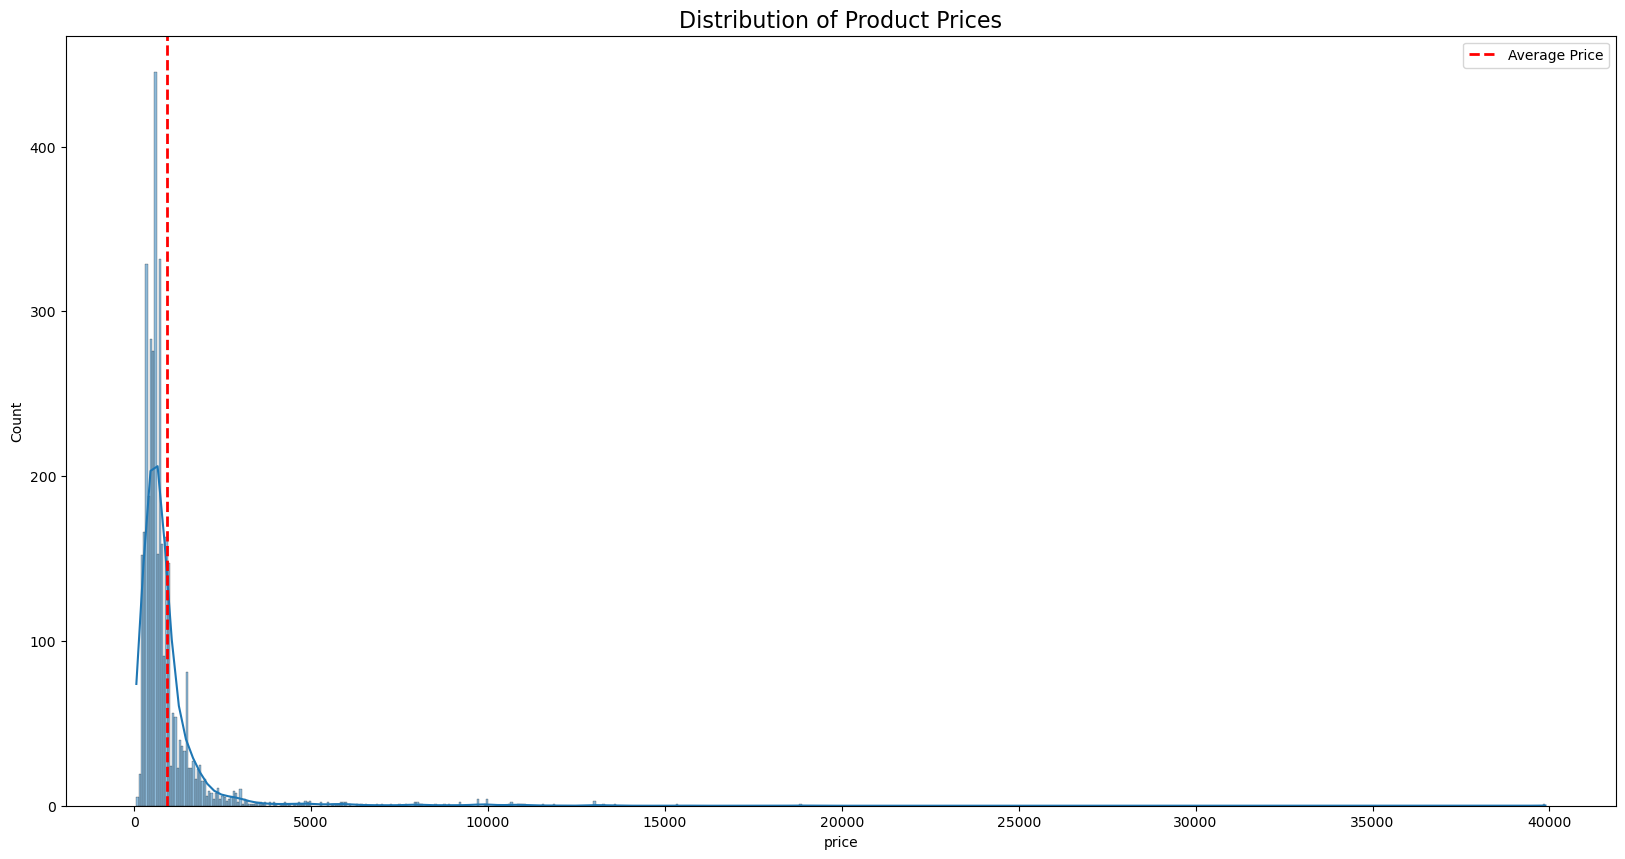

In [259]:
#distribution of prices

plt.figure(figsize=(20, 10))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Product Prices', fontsize=16)
plt.axvline(df['price'].mean(), color='red', linestyle='dashed', linewidth=2, label='Average Price')
plt.legend()  # Show legend for the annotation line
plt.show()

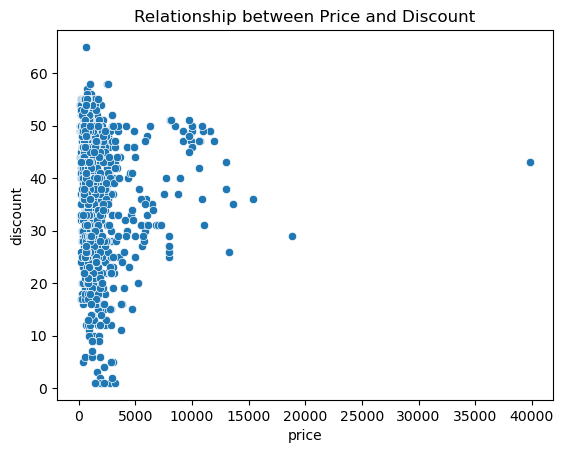

In [260]:
#relationship between prices and discount
sns.scatterplot(x='price', y='discount', data=df)
plt.title('Relationship between Price and Discount')
plt.show()

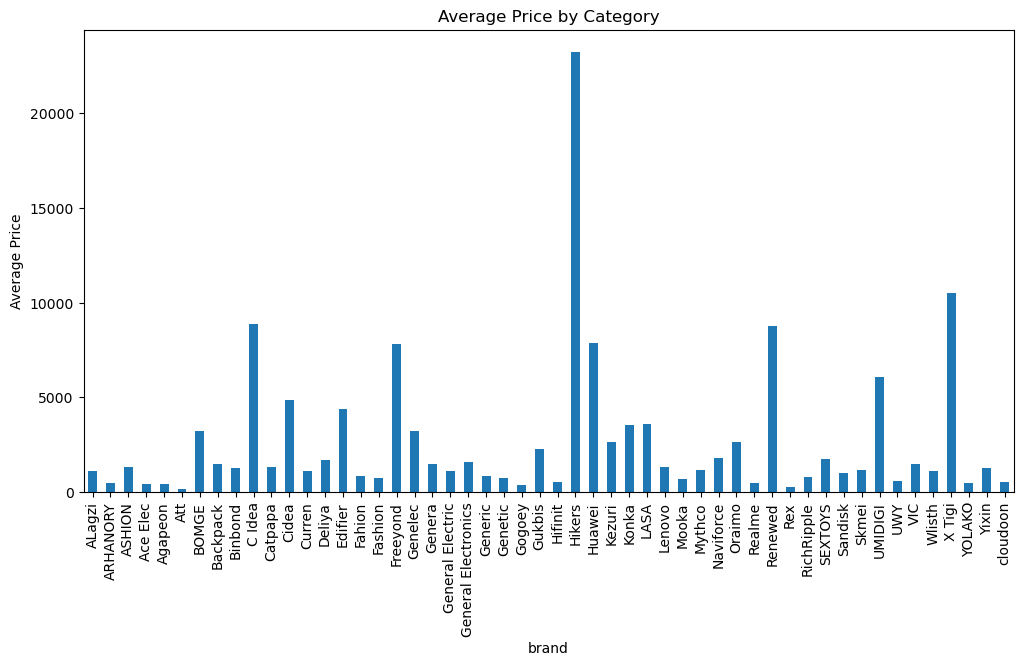

In [264]:
# average price per brand
plt.figure(figsize=(12, 6))
df.groupby('brand')['price'].mean().plot(kind='bar')
plt.title('Average Price by Category')
plt.xlabel('brand')
plt.ylabel('Average Price')
plt.show()


In [268]:
print(df.dtypes)

numeric_df = df.select_dtypes(include=[float, int])
correlation_matrix = numeric_df.corr()

name          object
price        float64
old_price      int32
discount     float64
brand         object
category      object
dtype: object


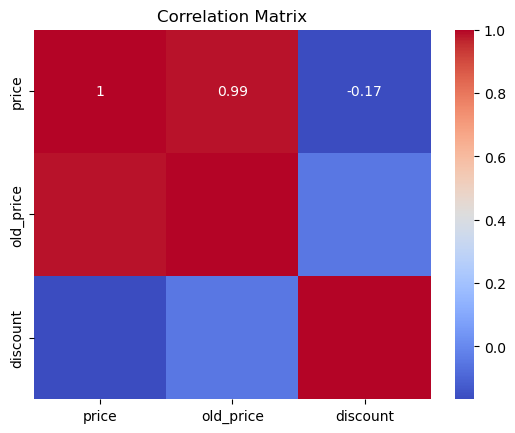

In [270]:

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
